In [23]:
# Import

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import joblib
from pathlib import Path
from IPython.display import display
from sqlalchemy import create_engine, MetaData, select
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from config import database_params

In [2]:
# Data Path

learning_data = Path('../Data_2/creditcard_2023.csv')

learning_df = pd.read_csv(learning_data, encoding='utf-8')

learning_df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [3]:
# Check data types

learning_df.dtypes

id          int64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [4]:
# Row count

num_rows = len(learning_df)
print("Number of rows:", num_rows)

Number of rows: 568630


In [5]:
# Cleaning

# Convert non-float values to NaN
learning_df = learning_df.apply(pd.to_numeric, errors='coerce')

# Drop rows containing NaN values
cleaned_learning_df = learning_df.dropna()

# Display the resulting DataFrame
print(cleaned_learning_df.head())

   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.146927 -0.038212 -0.214048 -1.893131  1.003963   
4 -0.212660  1.049921  ... -0.106984  0.729727 -0.161666  0.312561 -0.414116   

        V26       V27       V28    Amount  C

In [6]:
# Row count

num_rows = len(cleaned_learning_df)
print("Number of rows:", num_rows)

Number of rows: 568630


In [ ]:
# Export cleaned data

cleaned_learning_df.to_csv('../Data_2/cleaned_creditcard_2023.csv', encoding="utf-8", index=False, header=True)

In [7]:
# Creating SQL database

connection_params = database_params

connection = psycopg2.connect(**connection_params)

connection.autocommit = True

# Create a cursor object
cursor = connection.cursor()

# Create the database
cursor.execute("CREATE DATABASE creditcardtransactions")

# Commit the changes and close the connection to the default database
connection.commit()
cursor.close()
connection.close()

DuplicateDatabase: database "creditcardtransactions" already exists


In [ ]:
# Create the table

connection_params = { **database_params,
                     'dbname' : 'creditcardtransactions'}

connection = psycopg2.connect(**connection_params)

connection.autocommit = True

# Create a cursor object
cursor = connection.cursor()

# Create the table
create_credit_card_table = """
DROP TABLE IF EXISTS CreditCardTransactions;
CREATE TABLE CreditCardTransactions (
    id INT,
    V1 NUMERIC,
	V2 NUMERIC,
	V3 NUMERIC,
	V4 NUMERIC,
	V5 NUMERIC,
	V6 NUMERIC,
	V7 NUMERIC,
	V8 NUMERIC,
	V9 NUMERIC,
	V10 NUMERIC,
	V11 NUMERIC,
	V12 NUMERIC,
	V13 NUMERIC,
	V14 NUMERIC,
	V15 NUMERIC,
	V16 NUMERIC,
	V17 NUMERIC,
	V18 NUMERIC,
	V19 NUMERIC,
	V20 NUMERIC,
	V21 NUMERIC,
	V22 NUMERIC,
	V23 NUMERIC,
	V24 NUMERIC,
	V25 NUMERIC,
	V26 NUMERIC,
	V27 NUMERIC,
	V28 NUMERIC,
	Amount Numeric,
	class INT
);
"""

cursor.execute(create_credit_card_table)

# Commit the changes and close the connection
cursor.close()
connection.close()

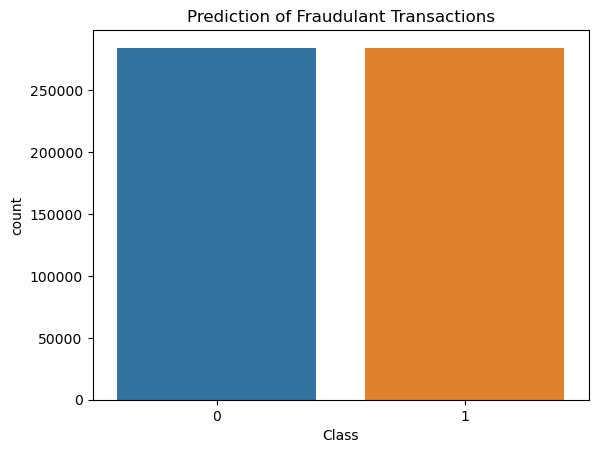

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

[[56684    66]
 [  118 56858]]


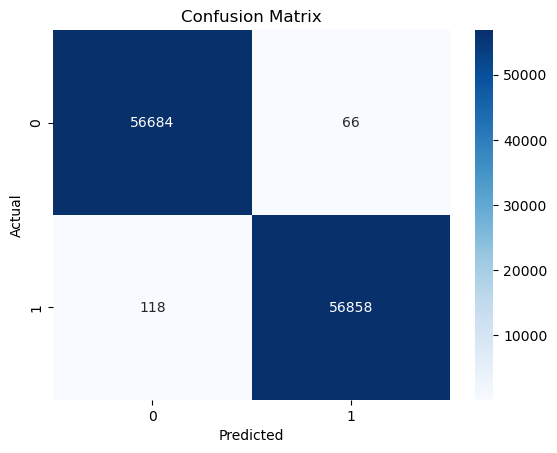

In [7]:
# Logistic Regression

# Check the distribution of the target variable (class)
sns.countplot(x = 'Class', data = cleaned_learning_df)
plt.title('Prediction of Fraudulant Transactions')
plt.show()

# Split the data into features (X) and target variable (y)
X = cleaned_learning_df.drop('Class', axis = 1)
y = cleaned_learning_df['Class']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

# Build a logistic regression model
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

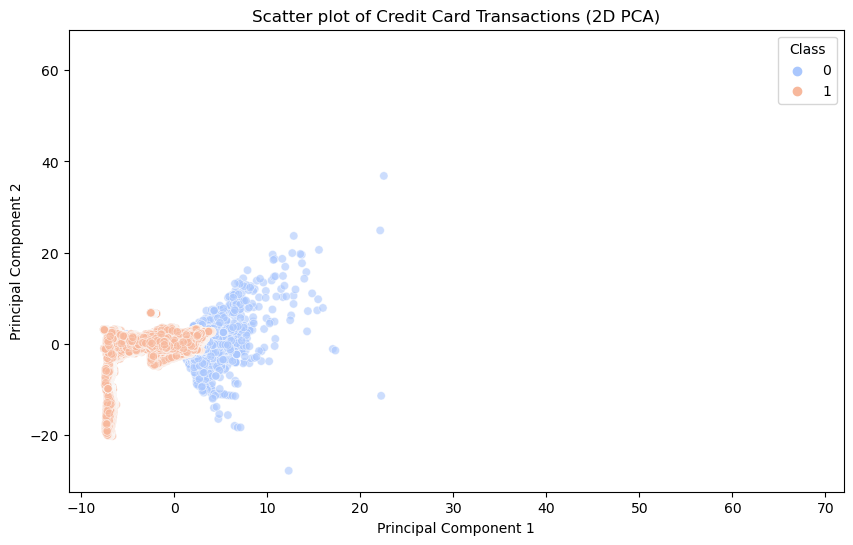

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

[[56684    66]
 [  118 56858]]


In [8]:
# Create a Scatter plot for different perspective

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot of the two principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.6)
plt.title('Scatter plot of Credit Card Transactions (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class', loc='upper right')
plt.show()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

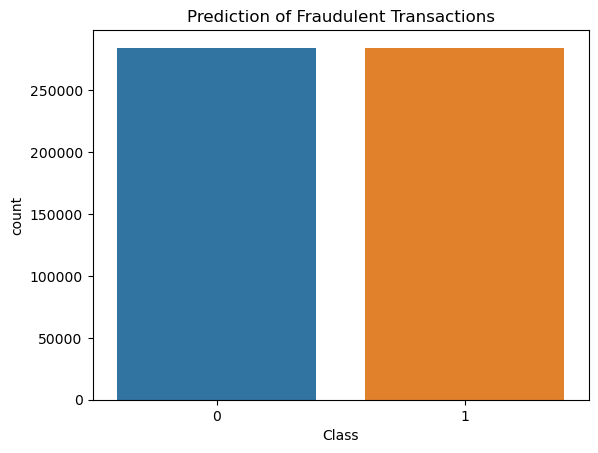

Max Iterations: 100
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

Accuracy: 0.998382076218279
Confusion Matrix:
[[56684    66]
 [  118 56858]]

Max Iterations: 500
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

Accuracy: 0.998382076218279
Confusion Matrix:
[[56684    66]
 [  118 56858]]

Max Iterations: 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1

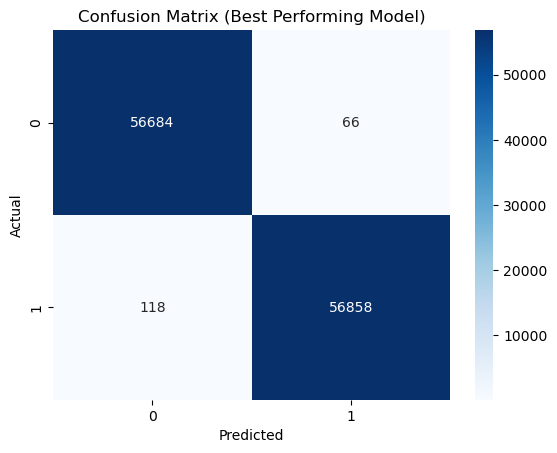

In [18]:
# Check the distribution of the target variable (class)
sns.countplot(x = 'Class', data = cleaned_learning_df)
plt.title('Prediction of Fraudulent Transactions')
plt.show()

# Split the data into features (X) and target variable (y)
X = cleaned_learning_df.drop('Class', axis=1)
y = cleaned_learning_df['Class']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialise lists to store optimisation results
accuracy_list = []
conf_matrix_list = []

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Perform model optimization
for max_iter in [100, 500, 1000]:
    
    # Build a logistic regression model
    model = LogisticRegression(max_iter=max_iter)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = model.score(X_test, y_test)
    accuracy_list.append(accuracy)
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_list.append(conf_matrix)

    print(f"Max Iterations: {max_iter}")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")

# Display overall model performance
best_max_iter = [100, 500, 1000][accuracy_list.index(max(accuracy_list))]
print(f"Best Max Iterations: {best_max_iter}")
print("Overall Model Performance:")
print(classification_report(y_test, model.predict(X_test)))
print(f"Overall Accuracy: {max(accuracy_list)}")
print(f"Overall Confusion Matrix:\n{conf_matrix_list[accuracy_list.index(max(accuracy_list))]}")

# Plot confusion matrix of the best performing model
plt.figure()
sns.heatmap(conf_matrix_list[accuracy_list.index(max(accuracy_list))], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Performing Model)')
plt.show()

In [11]:
# Save the trained model to a file
joblib.dump(model, 'logistic_regression_model.h5')

['logistic_regression_model.h5']

Model 1 - Report Explained
Precision: Precision measures the accuracy of the positive predictions made by the model. For class 0, it indicates the proportion of correctly predicted instances among all instances predicted as class 0. Similarly, for class 1, it represents the proportion of correctly predicted instances among all instances predicted as class 1. In this report, both classes have a precision of 1.00, indicating that all positive predictions made by the model were correct.

Recall: Recall, also known as sensitivity, measures the ability of the model to capture all positive instances of the class. For class 0, it represents the proportion of correctly predicted instances of class 0 among all actual instances of class 0. Similarly, for class 1, it indicates the proportion of correctly predicted instances of class 1 among all actual instances of class 1. Like precision, both classes have a recall of 1.00, indicating that the model correctly identified all instances of both classes.

F1-score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall and is particularly useful when the classes are imbalanced. Like precision and recall, the F1-score ranges from 0 to 1, with higher values indicating better performance. In this report, both classes have an F1-score of 1.00, indicating perfect balance between precision and recall.

Support: Support represents the number of actual occurrences of each class in the dataset. For class 0, there are 56,734 instances, and for class 1, there are 56,992 instances.

Accuracy: Accuracy measures the overall correctness of the model's predictions across all classes. In this case, the model achieved an accuracy of 1.00, indicating that all predictions, both positive and negative, were correct.

Additionally, the confusion matrix provided at the end of the report summarizes the model's predictions. In this case, the model made 56,669 correct predictions for class 0 and 56,870 correct predictions for class 1. It incorrectly classified 65 instances of class 0 as class 1 and 122 instances of class 1 as class 0.

In [12]:
# Number of classes in the training set before random oversampling
y_train.value_counts()

Class
0    227565
1    227339
Name: count, dtype: int64

Decision Tree model

In [13]:
# Separating Features and Target Variable
X = cleaned_learning_df.drop('Class', axis = 1)
y = cleaned_learning_df['Class']

# Splitting Data into Training and Test Sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Feature Scaling
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [14]:
from sklearn.tree import DecisionTreeClassifier

# Building and Training the Decision Tree Classifier
dt=DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeClassifier(random_state=42)

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [15]:
# Making Predictions 
y_test_pred=dt.predict(X_test_scaled)
y_train_pred=dt.predict(X_train_scaled)

In [16]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred_test = dt.predict(X_test_scaled)

# Predict on the training set (optional, for comparison)
y_pred_train = dt.predict(X_train_scaled)

# Calculate accuracy for test set
accuracy_test = accuracy_score(y_test, y_pred_test)

# Calculate accuracy for training set (optional, for comparison)
accuracy_train = accuracy_score(y_train, y_pred_train)

print("Accuracy on Test Set:", accuracy_test)
print("Accuracy on Training Set:", accuracy_train)

Accuracy on Test Set: 0.9995779329265075
Accuracy on Training Set: 1.0


In [17]:
import joblib

# Save the trained model to a file
joblib.dump(dt, 'decision_tree_model.h5')

['decision_tree_model.h5']

Logistic Regression

# Check the distribution of the target variable (class)
sns.countplot(x='class', data=cleaned_learning_df)
plt.title('Logistic Regression Prediction of Fraudulent Transactions')
plt.show()

# Split the data - features (X) and target variable (y)
X = cleaned_learning_df.drop('class', axis=1)
y = cleaned_learning_df['class']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = model.score(X_test, y_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Create a Scatter plot for different perspective

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot of the two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.6)
plt.title('Logistic Regression Scatter plot of Credit Card Transactions (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class', loc='upper right')
plt.show()

# Re-evaluate the model and print the accuracy and classification report
print(f"Logistic Regression Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Report
Precision: Precision measures the accuracy of the positive predictions made by the model. For class 0, it indicates the proportion of correctly predicted instances among all instances predicted as class 0. Similarly, for class 1, it represents the proportion of correctly predicted instances among all instances predicted as class 1. In this report, both classes have a precision of 1.00, indicating that all positive predictions made by the model were correct.

Recall: Recall, also known as sensitivity, measures the ability of the model to capture all positive instances of the class. For class 0, it represents the proportion of correctly predicted instances of class 0 among all actual instances of class 0. Similarly, for class 1, it indicates the proportion of correctly predicted instances of class 1 among all actual instances of class 1. Like precision, both classes have a recall of 1.00, indicating that the model correctly identified all instances of both classes.

F1-score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall and is particularly useful when the classes are imbalanced. Like precision and recall, the F1-score ranges from 0 to 1, with higher values indicating better performance. In this report, both classes have an F1-score of 1.00, indicating perfect balance between precision and recall.

Support: Support represents the number of actual occurrences of each class in the dataset. For class 0, there are 56,734 instances, and for class 1, there are 56,992 instances.

Accuracy: Accuracy measures the overall correctness of the model's predictions across all classes. In this case, the model achieved an accuracy of 1.00, indicating that all predictions, both positive and negative, were correct.

Additionally, the confusion matrix provided at the end of the report summarizes the model's predictions. In this case, the model made 56,669 correct predictions for class 0 and 56,870 correct predictions for class 1. It incorrectly classified 65 instances of class 0 as class 1 and 122 instances of class 1 as class 0.

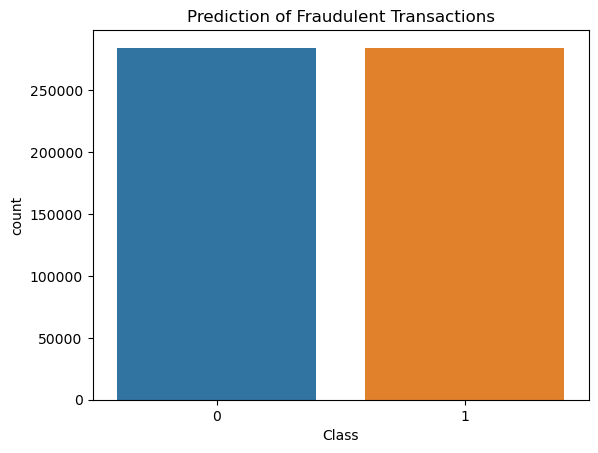

In [19]:
# Check the distribution of the target variable (class)
sns.countplot(x = 'Class', data = cleaned_learning_df)
plt.title('Prediction of Fraudulent Transactions')
plt.show()

In [21]:
# Split the data into features (X) and target variable (y)
X = cleaned_learning_df.drop('Class', axis=1)
y = cleaned_learning_df['Class']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialise lists to store optimisation results
accuracy_list = []
conf_matrix_list = []

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Perform model optimization
for max_iter in [100, 500, 1000]:
    
    # Build a logistic regression model
    model = LogisticRegression(max_iter=max_iter)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = model.score(X_test, y_test)
    accuracy_list.append(accuracy)
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_list.append(conf_matrix)

    print(f"Max Iterations: {max_iter}")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")

# Save the confusion matrix as an HDF5 file

joblib.dump(model, 'confusion_matrix.h5')

Max Iterations: 100
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

Accuracy: 0.998382076218279
Confusion Matrix:
[[56684    66]
 [  118 56858]]

Max Iterations: 500
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

Accuracy: 0.998382076218279
Confusion Matrix:
[[56684    66]
 [  118 56858]]

Max Iterations: 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1

['confusion_matrix.h5']

Best Max Iterations: 100
Overall Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

Overall Accuracy: 0.998382076218279
Overall Confusion Matrix:
[[56684    66]
 [  118 56858]]


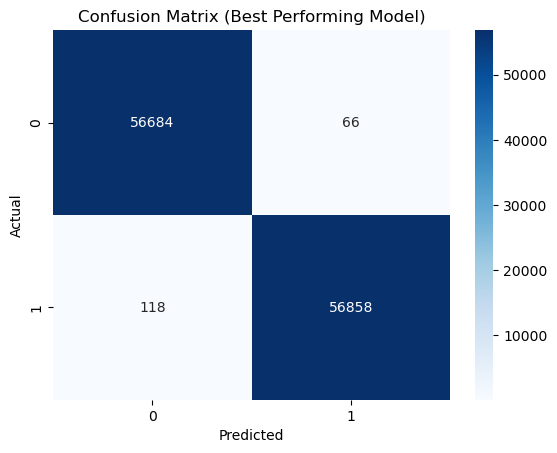

In [22]:
# Display overall model performance
best_max_iter = [100, 500, 1000][accuracy_list.index(max(accuracy_list))]
print(f"Best Max Iterations: {best_max_iter}")
print("Overall Model Performance:")
print(classification_report(y_test, model.predict(X_test)))
print(f"Overall Accuracy: {max(accuracy_list)}")
print(f"Overall Confusion Matrix:\n{conf_matrix_list[accuracy_list.index(max(accuracy_list))]}")

# Plot confusion matrix of the best performing model
plt.figure()
sns.heatmap(conf_matrix_list[accuracy_list.index(max(accuracy_list))], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Performing Model)')
plt.show()

In [26]:
# Random Forest

# Define target vector
y = cleaned_learning_df["Class"].ravel()
y[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [27]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [29]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [30]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [31]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)

In [32]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [33]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [34]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [35]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,56741,9
Actual 1,14,56962


Accuracy Score : 0.9997977595272849
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

